In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results2_dir          = config.get_property('results2_dir')
results_dir           = config.get_property('results_dir')
data_db_dir           = config.get_property('data_db_dir')
paper_dir             = config.get_property('paper_dir')
data_dir              = config.get_property('data_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute
import matplotlib.ticker as mtick


In [3]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

def simulate_abm(f, f0, g, θ, model_settings):
    dates_simulation      = model_settings["dates_simulation"]
    x                     = f0(θ)
    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

In [4]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
ward2buildingid        =  {row.ward: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/2265996033.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [5]:

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates


In [6]:
id_run       = 0
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )

posterior_df = pd.DataFrame()
for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
    os.makedirs(os.path.join(results2_dir,    "amro_inferences", "abm"), exist_ok=True)

    gammas        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")


    for idx_gamma, gamma in enumerate(gammas):
        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        inference = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        Nif       = θpost.shape[-1]

        ρ_post = θpost[0, :, :, :].mean(-2).flatten()
        β_post = θpost[1, :, :, :].mean(-2).flatten()

        post_df             = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
        post_df["value"]    = np.concatenate([ρ_post, β_post])
        post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]  = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
        post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
        post_df["gamma"]    = gamma
        post_df["amro"]     = amro
        posterior_df        = pd.concat([posterior_df, post_df])


Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


In [7]:
empirical_prevalence(amro)

array([0.5  , 0.406, 0.368])

In [8]:

print("amro \t Importation rate \gamma / Community prevalence \t Reference(s)")

for idx_amro, amro in enumerate(amro_search):
    ggg = empirical_prevalence(amro)*100
    s   = amro2title(amro)+"\t"+ "{:0.1f}".format(ggg[0])+" "+"{:0.1f}".format(ggg[1])+" "+"{:0.1f}".format(ggg[2]) + "\t"
    print(s)

amro 	 Importation rate \gamma / Community prevalence 	 Reference(s)
E. coli	70.0 63.0 55.0	
K. pneumoniae	35.0 23.0 15.0	
P. aeruginosa	25.0 18.8 11.6	
MSSA	35.0 29.0 25.0	
MRSA	10.0 5.0 3.9	
S. epidermidis	90.0 75.0 58.0	
E. faecalis	55.0 47.6 36.8	
E. faecium	50.0 40.6 36.8	


In [9]:
path_to_save_fig = os.path.join(results2_dir, "amro_inferences", "abm", "figures")

def add_subplot_axes(ax, rect, axisbg='w'):
    fig    = plt.gcf()
    box    = ax.get_position()
    height = box.height
    width  = box.width

    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure    = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x              = infig_position[0]
    y              = infig_position[1]
    width         *= rect[2]
    height        *= rect[3]

    subax       = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)

    return subax


rect1      = (0.15,  0.16,
                0.45,  0.45)
rect2      = (0.5,   0.08,
                0.45, 0.45)
rect3      = (0.5,   0.08,
                0.45, 0.45)
rect4      = (0.5,   0.08,
                0.45, 0.45)
rect6      = (0.5,   0.08,
                0.45, 0.45)
rect7      = (0.5,   0.08,
                0.45, 0.45)
rect8      = (0.5,   0.08,
                0.45, 0.45)

rect  = [rect1, rect2, rect3, rect4, None, rect6, rect7, rect8]


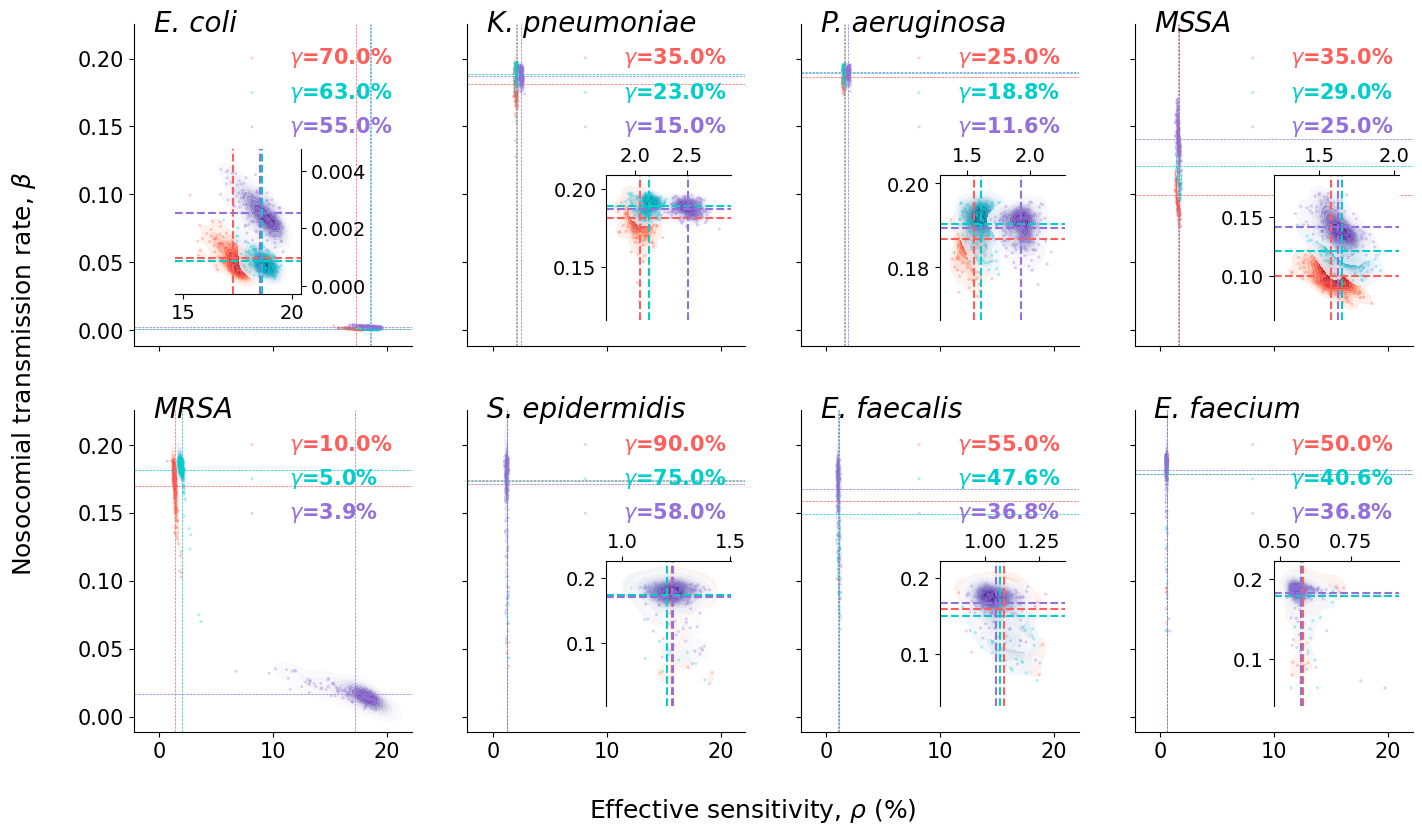

In [10]:
from diagnostic_plots import convergence_plot
from utils_local import plot_utils
import seaborn as sns

COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]
CMAPS_GAMMA  = ["Reds", "Blues", "Purples"]
v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

fig, ax = plt.subplots(2, 4, figsize=(16.5, 9.2), sharex=True, sharey=True)

for idx_axi, axi in enumerate(ax.flatten()):
    amro    = amro_search[idx_axi]
    amro_df = v_df[v_df.amro==amro]
    gammas  = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_g, gamma in enumerate(gammas):
        rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ'")
        beta_df = amro_df.query(f"gamma=={gamma} and param=='β'")

        sns.kdeplot(ax    = axi,
                    x     = rho_df["value"].values * 100,
                    y     = beta_df["value"].values,
                    cmap  = CMAPS_GAMMA[idx_g],
                    fill  = True,
                    alpha = 0.7)

        axi.scatter(rho_df["value"].values * 100,
                    beta_df["value"].values,
                    fc        = COLORS_GAMMA[idx_g],
                    ec        = None,
                    alpha     = 0.3,
                    s         = 5,
                    label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))

        axi.axhline(y     = np.mean(beta_df["value"].values),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

        axi.axvline(x     = np.mean(rho_df["value"].values*100),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

    axi.set_ylim((-0.011310953055567037, 0.2257557217477729))
    axi.set_xlim((-2.2376656192686055, 22.171308067653385))

    axi.text(x       = -0.5,
            y        = 0.22,
            s        = f"{amro2title(amro)}",
            style    = 'italic',
            weight   = 'normal',
            color    = "k",
            fontsize = 20)

    l = axi.legend(loc             = "upper right",
                    frameon        = False,
                    prop           = {"weight": 'bold'},
                    bbox_to_anchor = [1, 0.99])

    for idx_t, text in enumerate(l.get_texts()):
        text.set_color(COLORS_GAMMA[idx_t])

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)

    if idx_axi != 4:
        ax_zoomed          = add_subplot_axes(axi, rect[idx_axi], axisbg='w')

        for idx_g, gamma in enumerate(gammas):
            rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ'")
            beta_df = amro_df.query(f"gamma=={gamma} and param=='β'")

            sns.kdeplot(ax     = ax_zoomed,
                        x      = rho_df["value"].values * 100,
                        y      = beta_df["value"].values,
                        cmap   = CMAPS_GAMMA[idx_g],
                        fill   = True,
                        alpha  = 0.8)

            ax_zoomed.scatter(rho_df["value"].values * 100,
                                beta_df["value"].values,
                                fc        = COLORS_GAMMA[idx_g],
                                ec        = None,
                                alpha     = 0.3,
                                s         = 5,
                                label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))

            ax_zoomed.axhline(y       = np.mean(beta_df["value"].values),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])

            ax_zoomed.axvline(x   = np.mean(rho_df["value"].values*100),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])

            ax_zoomed.tick_params(axis = 'both',
                                    labelsize = 14)

            if idx_axi!=0:
                ax_zoomed.spines['bottom'].set_visible(False)
                ax_zoomed.spines['right'].set_visible(False)
                ax_zoomed.xaxis.set_label_position('top')
                ax_zoomed.xaxis.tick_top()
            else:
                ax_zoomed.spines['left'].set_visible(False)
                ax_zoomed.spines['top'].set_visible(False)
                ax_zoomed.yaxis.set_label_position('right')
                ax_zoomed.yaxis.tick_right()

#ax[0, 0].set_ylabel(r"$\beta$")
#ax[1, 0].set_ylabel(r"$\beta$")
#for i in range(4):
#    ax[1, i].set_xlabel(r"$\rho$ (%)")

fig.supxlabel(r'Effective sensitivity, $\rho$ (%)')
fig.supylabel(r'Nosocomial transmission rate, $\beta$', x=0.05)

fig.savefig(os.path.join(results2_dir, "paper_figures", "fig3.png"),
                                            dpi=300, transparent=True)


In [11]:
def num2table(num):
    if num < 0.1:
        return "{:0.2E}".format(num)
    return "{:0.3f}".format(num)


means_paper_df = pd.DataFrame()
for amro in amro_search:
    amro_df          = v_df[v_df.amro==amro]
    amro_df["gamma"] = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
    amro_df["value"] = amro_df.apply(lambda x: x["value"] * 100 if x["param"] == "ρ" else x["value"], axis=1)
    amro_q_df        = amro_df.groupby(["param", "gamma"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_2": "stat"}).replace( {1-0.05: "high95", 0.05: "low95"})
    amro_df          = amro_df.groupby(["param", "gamma"]).mean()[["value"]].reset_index()
    amro_df["stat"]  = "mean"
    amro_df          = pd.concat([amro_df, amro_q_df])

    means_df                  = pd.pivot(amro_df, index="gamma", columns=["param", "stat"], values="value")
    means_df["amro"]          = amro2title(amro)
    means_df[("ρ", "mean")]   = means_df[("ρ", "mean")].map(lambda x: "{:0.2f}".format(x))
    means_df[("ρ", "high95")] = means_df[("ρ", "high95")].map(lambda x: "{:0.2f}".format(x))
    means_df[("ρ", "low95")]  = means_df[("ρ", "low95")].map(lambda x: "{:0.2f}".format(x))

    means_df[("β", "mean")]   = means_df[("β", "mean")].map(lambda x:   num2table(x))
    means_df[("β", "high95")] = means_df[("β", "high95")].map(lambda x: num2table(x))
    means_df[("β", "low95")]  = means_df[("β", "low95")].map(lambda x:  num2table(x))
    means_paper_df  = pd.concat([means_paper_df, means_df])

means_paper_df  = means_paper_df.reset_index()[[('amro', ''), ('gamma', ''), ('β', 'mean'), ('β', 'low95'), ('β', 'high95'), ('ρ', 'mean'), ('ρ', 'low95'), ('ρ', 'high95')]]
means_paper_df  = means_paper_df.rename(columns={"gamma": "γ"})
means_paper_df

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/1415280562.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amro_df["gamma"] = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/1415280562.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amro_df["value"] = amro_df.apply(lambda x: x["value"] * 100 if x["param"] == "ρ" else x["value"], axis=1)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/1415280

param            amro      γ         β                          ρ         \
stat                              mean     low95    high95   mean  low95   
0             E. coli  55.0%  2.54E-03  1.72E-03  3.58E-03  18.53  17.30   
1             E. coli  63.0%  8.66E-04  3.78E-04  1.58E-03  18.63  17.85   
2             E. coli  70.0%  9.62E-04  4.06E-04  1.73E-03  17.31  16.33   
3       K. pneumoniae  15.0%     0.187     0.180     0.194   2.51   2.36   
4       K. pneumoniae  23.0%     0.189     0.180     0.195   2.14   1.98   
5       K. pneumoniae  35.0%     0.181     0.165     0.193   2.05   1.92   
6       P. aeruginosa  11.6%     0.189     0.183     0.194   1.93   1.78   
7       P. aeruginosa  18.8%     0.190     0.182     0.195   1.61   1.47   
8       P. aeruginosa  25.0%     0.187     0.178     0.194   1.55   1.43   
9                MSSA  25.0%     0.141     0.122     0.164   1.63   1.47   
10               MSSA  29.0%     0.121     0.103     0.140   1.65   1.49   
11               MSSA  35.0%  9.94E-02  8.43E-02     0.116   1.58   1.40   
12               MRSA  10.0%     0.170     0.136     0.184   1.38   1.21   
13               MRSA   3.9%  1.70E-02  9.16E-03  2.74E-02  17.15  12.48   
14               MRSA   5.0%     0.182     0.168     0.190   1.96   1.72   
15     S. epidermidis  58.0%     0.171     0.117     0.190   1.24   1.12   
16     S. epidermidis  75.0%     0.174     0.134     0.190   1.21   1.10   
17     S. epidermidis  90.0%     0.173     0.107     0.189   1.23   1.12   
18        E. faecalis  36.8%     0.167     0.121     0.186   1.05   0.96   
19        E. faecalis  47.6%     0.149  9.69E-02     0.182   1.07   0.96   
20        E. faecalis  55.0%     0.159     0.101     0.185   1.09   0.96   
21         E. faecium  36.8%     0.182     0.163     0.192   0.58   0.54   
22         E. faecium  40.6%     0.179     0.147     0.191   0.57   0.54   
23         E. faecium  50.0%     0.178     0.123     0.193   0.58   0.54   

param         
stat  high95  
0      19.43  
1      19.23  
2      18.02  
3       2.65  
4       2.29  
5       2.17  
6       2.07  
7       1.75  
8       1.67  
9       1.79  
10      1.81  
11      1.73  
12      1.60  
13     18.96  
14      2.19  
15      1.35  
16      1.33  
17      1.36  
18      1.17  
19      1.19  
20      1.21  
21      0.63  
22      0.65  
23      0.66

In [12]:
print("amro \t gamma \t Nosocomial transmission \t Likelihood of detection")

print("amro \t \t mean (95% CI) \t mean (95% CI)")
table = []
for idx_row, row in means_paper_df.iterrows():
    s = row[('amro',       '')]+"\t"+row[('γ', '')]+"\t"+ row[('β',   'mean')]+" ({}, {})".format(row[('β', 'low95')], row[('β', 'high95')])+ "\t"  + row[('ρ',   'mean')]+" ({}, {})".format(row[('ρ', 'low95')], row[('ρ', 'high95')])
    print(s)

amro 	 gamma 	 Nosocomial transmission 	 Likelihood of detection
amro 	 	 mean (95% CI) 	 mean (95% CI)
E. coli	55.0%	2.54E-03 (1.72E-03, 3.58E-03)	18.53 (17.30, 19.43)
E. coli	63.0%	8.66E-04 (3.78E-04, 1.58E-03)	18.63 (17.85, 19.23)
E. coli	70.0%	9.62E-04 (4.06E-04, 1.73E-03)	17.31 (16.33, 18.02)
K. pneumoniae	15.0%	0.187 (0.180, 0.194)	2.51 (2.36, 2.65)
K. pneumoniae	23.0%	0.189 (0.180, 0.195)	2.14 (1.98, 2.29)
K. pneumoniae	35.0%	0.181 (0.165, 0.193)	2.05 (1.92, 2.17)
P. aeruginosa	11.6%	0.189 (0.183, 0.194)	1.93 (1.78, 2.07)
P. aeruginosa	18.8%	0.190 (0.182, 0.195)	1.61 (1.47, 1.75)
P. aeruginosa	25.0%	0.187 (0.178, 0.194)	1.55 (1.43, 1.67)
MSSA	25.0%	0.141 (0.122, 0.164)	1.63 (1.47, 1.79)
MSSA	29.0%	0.121 (0.103, 0.140)	1.65 (1.49, 1.81)
MSSA	35.0%	9.94E-02 (8.43E-02, 0.116)	1.58 (1.40, 1.73)
MRSA	10.0%	0.170 (0.136, 0.184)	1.38 (1.21, 1.60)
MRSA	3.9%	1.70E-02 (9.16E-03, 2.74E-02)	17.15 (12.48, 18.96)
MRSA	5.0%	0.182 (0.168, 0.190)	1.96 (1.72, 2.19)
S. epidermidis	58.0%	0.171 (0.1

In [13]:
amro_plot_df = pd.DataFrame()
for amro in amro_search:
    amro_df                = v_df[v_df.amro==amro]
    gammas                 = amro_df["gamma"].unique()
    amro2level             = {gammas[2]: "low", gammas[1]: "medium",  gammas[0]: "high"}
    amro_df["gamma_level"] = amro_df["gamma"].map(amro2level)

    amro_df["gamma"]       = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
    amro_df["value"]       = amro_df.apply(lambda x: x["value"] * 100 if x["param"] == "ρ" else x["value"], axis=1)
    amro_q_df              = amro_df.groupby(["param", "gamma", "gamma_level"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_3": "stat"}).replace( {1-0.05: "high95", 0.05: "low95"})
    amro_df                = amro_df.groupby(["param", "gamma", "gamma_level"]).mean()[["value"]].reset_index()
    amro_q_df["amro"]      = amro
    amro_df["amro"]        = amro

    amro_df["stat"]        = "mean"
    amro_plot_df           = pd.concat([amro_plot_df, amro_df, amro_q_df[list(amro_df.columns)]])


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/3814777323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amro_df["gamma_level"] = amro_df["gamma"].map(amro2level)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/3814777323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amro_df["gamma"]       = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/3814777323.py:9: SettingWithCopyWarning: 
A value i

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/4285096562.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([amro2title(amro) for amro in amro_search], style='italic')


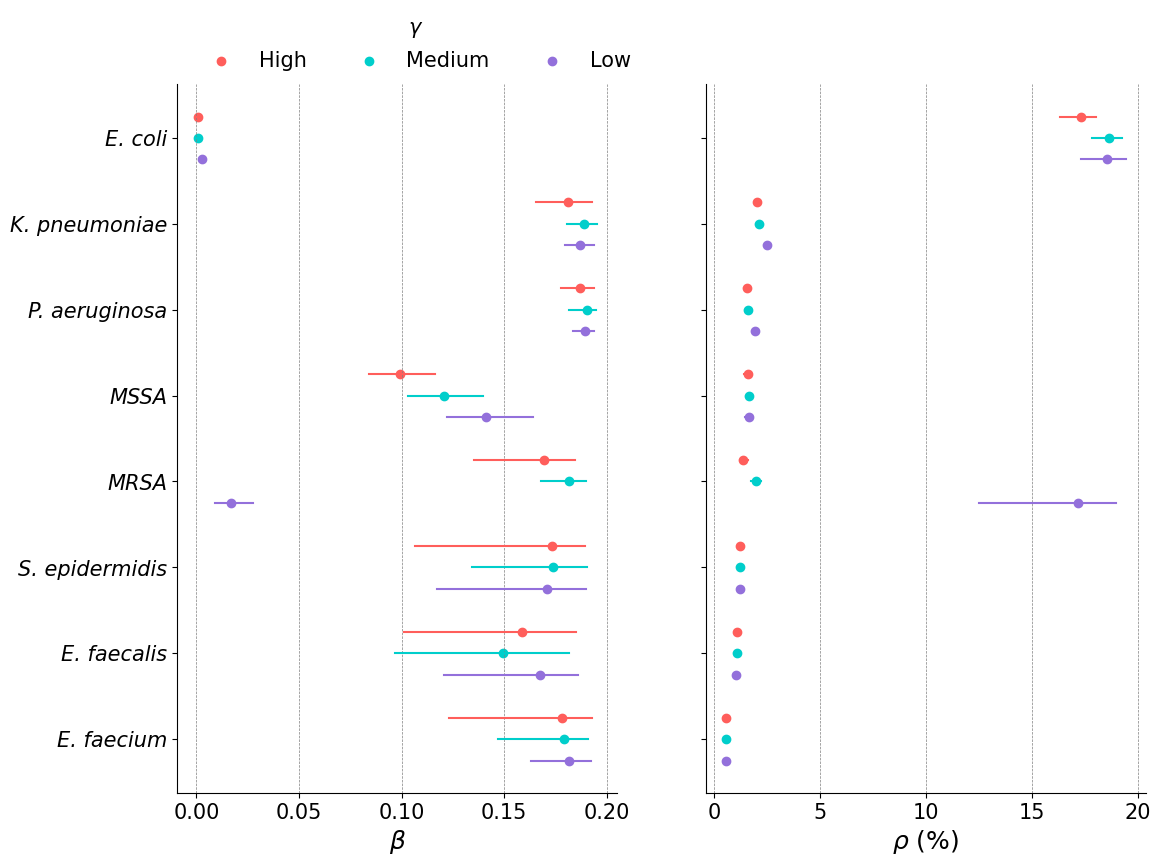

In [14]:
step = 2
ypos = np.flip(np.arange(0, len(amro_search) * step, step))


fig, ax = plt.subplots(1, 2, figsize=(12.5, 9.2), sharey=True)
for idx_gamma, gamma_level in  enumerate(["high", "medium", "low"]):

    β_upp  = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='high95'")["value"].values
    β_low  = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='low95'")["value"].values
    β_mean = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='mean'")["value"].values

    ax[0].scatter(x = β_mean,
                  y = ypos + step/4 * (2-idx_gamma),
                  c = COLORS_GAMMA[idx_gamma],
                  label=gamma_level.capitalize())
    ax[0].plot(np.concatenate([[β_low], [β_upp]]),
               np.concatenate([[ypos], [ypos]]) + step/4 * (2-idx_gamma),
                color = COLORS_GAMMA[idx_gamma])

    ρ_upp  = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='high95'")["value"].values
    ρ_low  = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='low95'")["value"].values
    ρ_mean = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='mean'")["value"].values

    ax[1].scatter(x = ρ_mean,
                  y = ypos + step/4 * (2-idx_gamma),
                  c = COLORS_GAMMA[idx_gamma])
    ax[1].plot(np.concatenate([[ρ_low], [ρ_upp]]),
               np.concatenate([[ypos], [ypos]]) + step/4 * (2-idx_gamma),
               color = COLORS_GAMMA[idx_gamma])

for axi in ax.flatten():
    axi.grid(axis='x', color='grey', linestyle='--', linewidth=0.5)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend().remove()


ax[0].legend(bbox_to_anchor=(0.01, 1.12), title=r"$\gamma$", loc="upper left", frameon=False, ncol=3)
ax[0].set_yticklabels([amro2title(amro) for amro in amro_search], style='italic')
ax[0].set_yticks(ypos + step/4)

ax[1].set_xlabel(r"$\rho$ (%)")
ax[0].set_xlabel(r"$\beta$")

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures", "MarginalPosteriorEstimates_figS10.png"),
                                                                    dpi=300, transparent=True, bbox_inches = 'tight')


# just enterococcus species


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/1964239124.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([amro2title(amro) for amro in ["ENTEROCOCCUS FAECALIS", "ENTEROCOCCUS FAECIUM"]], style='italic')


Text(0.5, 0, '$\\beta$')

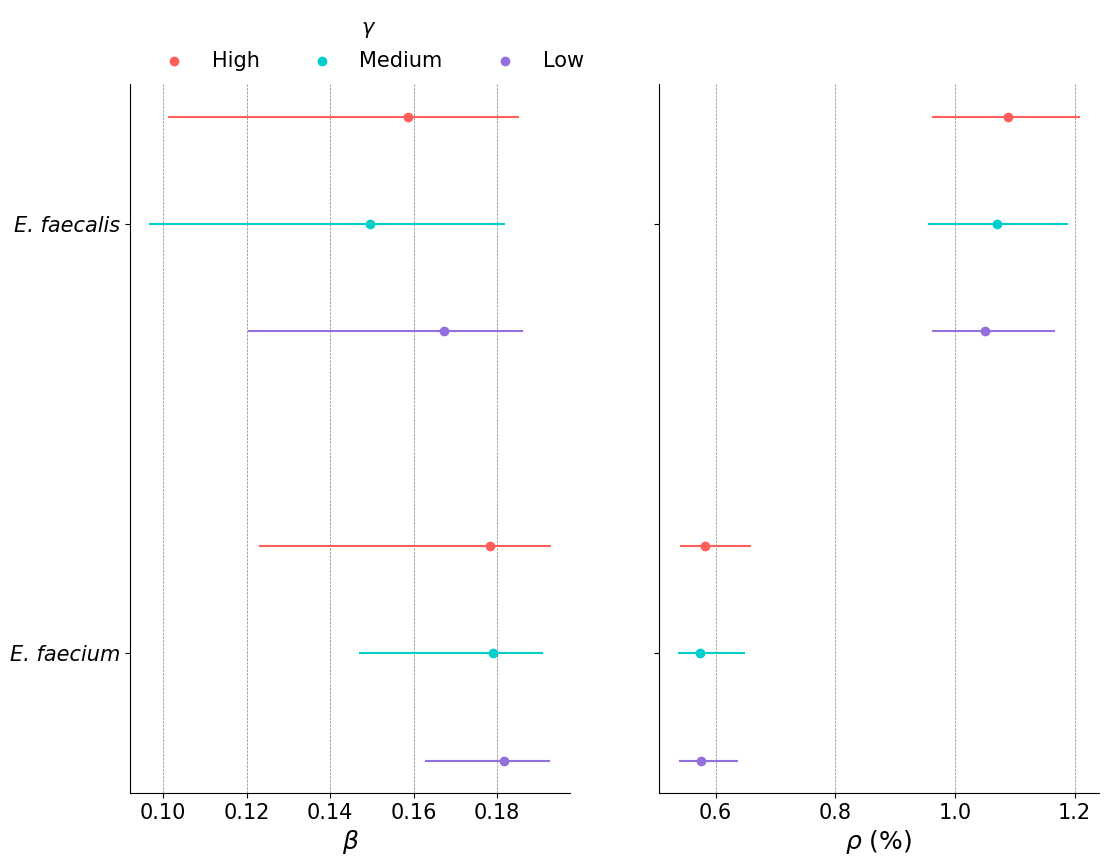

In [26]:

step = 2
ypos = np.flip(np.arange(0, 2 * step, step))


fig, ax = plt.subplots(1, 2, figsize=(12.5, 9.2), sharey=True)
for idx_gamma, gamma_level in  enumerate(["high", "medium", "low"]):

    amro_plot_enterococcus_df = amro_plot_df[amro_plot_df["amro"].isin(["ENTEROCOCCUS FAECALIS", "ENTEROCOCCUS FAECIUM"])]

    β_upp  = amro_plot_enterococcus_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='high95'")["value"].values
    β_low  = amro_plot_enterococcus_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='low95'")["value"].values
    β_mean = amro_plot_enterococcus_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='mean'")["value"].values

    ax[0].scatter(x = β_mean,
                  y = ypos + step/4 * (2-idx_gamma),
                  c = COLORS_GAMMA[idx_gamma],
                  label=gamma_level.capitalize())
    ax[0].plot(np.concatenate([[β_low], [β_upp]]),
               np.concatenate([[ypos], [ypos]]) + step/4 * (2-idx_gamma),
                color = COLORS_GAMMA[idx_gamma])

    ρ_upp  = amro_plot_enterococcus_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='high95'")["value"].values
    ρ_low  = amro_plot_enterococcus_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='low95'")["value"].values
    ρ_mean = amro_plot_enterococcus_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='mean'")["value"].values

    ax[1].scatter(x = ρ_mean,
                  y = ypos + step/4 * (2-idx_gamma),
                  c = COLORS_GAMMA[idx_gamma])
    ax[1].plot(np.concatenate([[ρ_low], [ρ_upp]]),
               np.concatenate([[ypos], [ypos]]) + step/4 * (2-idx_gamma),
               color = COLORS_GAMMA[idx_gamma])

for axi in ax.flatten():
    axi.grid(axis='x', color='grey', linestyle='--', linewidth=0.5)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend().remove()


ax[0].legend(bbox_to_anchor=(0.01, 1.12), title=r"$\gamma$", loc="upper left", frameon=False, ncol=3)
ax[0].set_yticklabels([amro2title(amro) for amro in ["ENTEROCOCCUS FAECALIS", "ENTEROCOCCUS FAECIUM"]], style='italic')
ax[0].set_yticks(ypos + step/4)

ax[1].set_xlabel(r"$\rho$ (%)")
ax[0].set_xlabel(r"$\beta$")

#fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures", "MarginalPosteriorEstimates_figS10.png"),
#                                                                    dpi=300, transparent=True, bbox_inches = 'tight')



In [30]:

amro_plot_enterococcus_df.query("stat=='mean' and gamma_level=='low' and param=='β'")



,param,gamma,gamma_level,value,amro,stat
0,β,36.8%,low,0.167367,ENTEROCOCCUS FAECALIS,mean
0,β,36.8%,low,0.181728,ENTEROCOCCUS FAECIUM,mean


In [15]:
from eval.calibration import calibration
from utils import create_df_response

def create_sim_df(sim_samples, model_settings):
    """ Sample from the posterior simulation

    Args:
        sim_samples: Array with shape (k: num_observations, m: num_samples, T: length of simulation)
        model_settings: _description_
    """
    k, m , T = sim_samples.shape
    y = sim_samples

    sim_df = pd.DataFrame()
    for ki in range(model_settings["k"]):
        df           = pd.DataFrame(np.squeeze(y[ki, :, :]).flatten(), columns=["value"])
        df["date"]   = flatten_list([list(model_settings["dates_simulation"])] * model_settings["m"])
        df["ens_id"] = flatten_list([[mi]*model_settings["T"] for mi in range(model_settings["m"])])
        df           = df.set_index(["date", "ens_id"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
        df["yi"]     = ki
        sim_df       = pd.concat([sim_df, df])
    return sim_df

def create_obs_building_amro(amro, model_settings, ward2building_dict, path_to_data, resample="W-Sun", p_oev=0.2):
    k                     = model_settings["k"]
    amro_df               = pd.read_csv(path_to_data, parse_dates=["date"]).drop(columns=["Unnamed: 0"])
    amro_df               = amro_df[amro_df["amro"]==amro]

    amro_df["buildingid"] = amro_df["ward_total"].map(ward2building_dict)

    amro_df               = amro_df.groupby(["date", "buildingid"]).sum(numeric_only=True).unstack([1]).resample(resample).sum(numeric_only=True).stack().reset_index()
    amro_df["obs_name"]   = amro_df["buildingid"].map({i: f"y{i+1}" for i in range(k)})
    amro_df               = pd.pivot(amro_df, index="date", columns="obs_name", values="num_positives").reset_index()
    for i in range(k):
        amro_df['oev'+str(i+1)] = 1 +(p_oev * amro_df['y'+str(i+1)].values)**2
    amro_df = amro_df.set_index("date")
    return amro_df

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_27707/1500616397.py:94: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


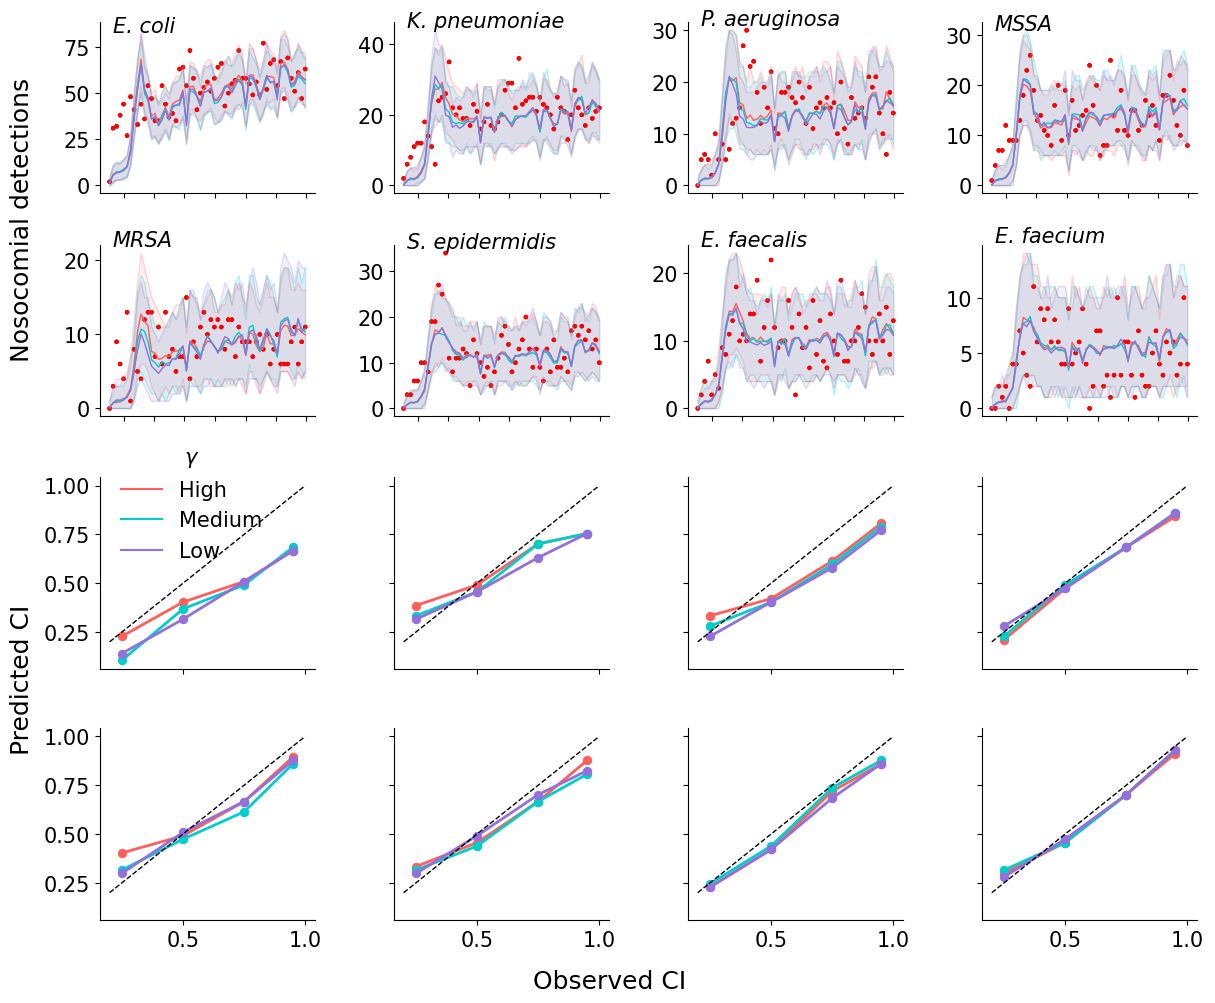

In [16]:
from matplotlib import dates as mdates
import seaborn as sns

COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]


fig     = plt.figure(constrained_layout=True, figsize=(12.5, 9.2))
subfigs = fig.subfigures(2, 1, hspace=0.05, wspace=0.05, height_ratios=[0.45, 0.55])

axes   = subfigs[0].subplots(2, 4, sharex="col")
axes_c = subfigs[1].subplots(2, 4, sharex=True, sharey=True)

for idx_amro, amro in enumerate(amro_search):
    gammas       = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df       = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")

    hosp_calibration_df = pd.DataFrame()
    for idx_gamma, gamma in enumerate(gammas):
        gamma2level = {gammas[0]:  "High",
                        gammas[1]: "Medium",
                        gammas[2]: "Low"}

        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        sim_post        = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"))
        sim_df          = create_sim_df(sim_post["y"].transpose(1, 2, 0), model_settings)
        hosp_df         = sim_df.groupby(["date", "ens_id"]).sum()[["value"]].reset_index()
        hosp_samples    = hosp_df.pivot(index="date", columns="ens_id", values="value").to_numpy()
        hosp_samples    = np.expand_dims(hosp_samples, 0)

        c_df                = calibration(hosp_samples, np.expand_dims(obs_df[[f"y{i+1}" for i in range(model_settings["k"])]].sum(axis=1).to_numpy(), 0))
        c_df["observation"] = "agg"
        c_df["amro"]        = amro
        c_df["gamma"]       = gamma
        hosp_calibration_df = pd.concat([hosp_calibration_df, c_df])

        hosp_df = create_df_response(np.squeeze(hosp_samples), time   = len(if_settings["assimilation_dates"]),
                                                                dates = if_settings["assimilation_dates"])
        axi     = axes.flatten()[idx_amro]

        axi.plot(if_settings["assimilation_dates"],         hosp_df["mean"],   color=COLORS_GAMMA[idx_gamma],    lw=1.0, label=r"{}".format(gamma2level[gamma]))
        axi.fill_between(if_settings["assimilation_dates"], hosp_df["low_95"], hosp_df["high_95"],     color=COLORS_GAMMA[idx_gamma], alpha=0.1)
        axi.plot(if_settings["assimilation_dates"],         hosp_df["low_95"],  color=COLORS_GAMMA[idx_gamma], lw=0.8, alpha=0.2)
        axi.plot(if_settings["assimilation_dates"],         hosp_df["high_95"], color=COLORS_GAMMA[idx_gamma], lw=0.8, alpha=0.2)

        y_hosp  =  obs_df[[f"y{i+1}" for i in range(model_settings["k"])]].sum(axis=1)

        axi.scatter(if_settings["assimilation_dates"], y_hosp, ec=None, fc="r", s=10)

        axi.tick_params(which='both', axis='x', labelrotation=75)
        axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.legend().remove()
        axi.set_ylabel(None)
        axi.set_xlabel(None)

    # plot for the legend
    axi.text(x       = 18300,
            y        = np.maximum(hosp_df["high_95"].max(), np.max(y_hosp))+1,
            s        = f"{amro2title(amro)}",
            style    = 'italic',
            weight   = 'normal',
            color    = "k")

    ax_c = axes_c.flatten()[idx_amro]

    hosp_calibration_df["gamma_legend"] = hosp_calibration_df["gamma"].map(gamma2level)
    sns.lineplot(ax     = ax_c,
                data    = hosp_calibration_df,
                x       = "quantiles",
                y       = "proportion_inside",
                marker  = "o",
                mec     = None,
                hue     = "gamma_legend",
                palette = COLORS_GAMMA,
                lw      = 2)

    iden = np.arange(0.2, 1.1, 0.1)
    ax_c.plot(iden, iden, color="k", lw=1.0, ls="--")
    ax_c.spines['right'].set_visible(False)
    ax_c.spines['top'].set_visible(False)
    ax_c.legend().remove()
    ax_c.set_ylabel(None)
    ax_c.set_xlabel(None)

    if idx_amro == 0:
        axes_c[0, 0].legend(bbox_to_anchor = (0.01, 1.25),
                            title          = r"$\gamma$",
                            loc            = "upper left",
                            frameon        = False, ncol=1)

#subfigs[1].subplots_adjust(wspace=0.1)
plt.tight_layout()

subfigs[1].subplots_adjust(top=0.9)

subfigs[1].supxlabel(r'Observed CI', y=-0.12)
subfigs[1].supylabel(r'Predicted CI')
subfigs[0].supylabel(r'Nosocomial detections')

#fig.suptitle("Calibration at hospital level.")
fig.savefig(os.path.join(results2_dir, "paper_figures", "fig4.png"),
                                                            dpi         = 300,
                                                            transparent = True,
                                                            bbox_inches = 'tight')


In [17]:
totals_df         = pd.DataFrame(columns=["amro", "total"])
totals_df["amro"] = amro_search

total = []
for idx_amro, amro in enumerate(amro_search):
    gammas   = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df   = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    t = obs_df[["y1", "y2", "y3", "y4",	"y5", "y6"]].sum(axis=1).sum()
    total.append(t)

totals_df["total"] = total
totals_df

,amro,total
0,ESCHERICHIA COLI,2890
1,KLEBSIELLA PNEUMONIAE,1139
2,PSEUDOMONAS AERUGINOSA,809
3,METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS,773
4,METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS,486
5,STAPHYLOCOCCUS EPIDERMIDIS,694
6,ENTEROCOCCUS FAECALIS,596
7,ENTEROCOCCUS FAECIUM,263
